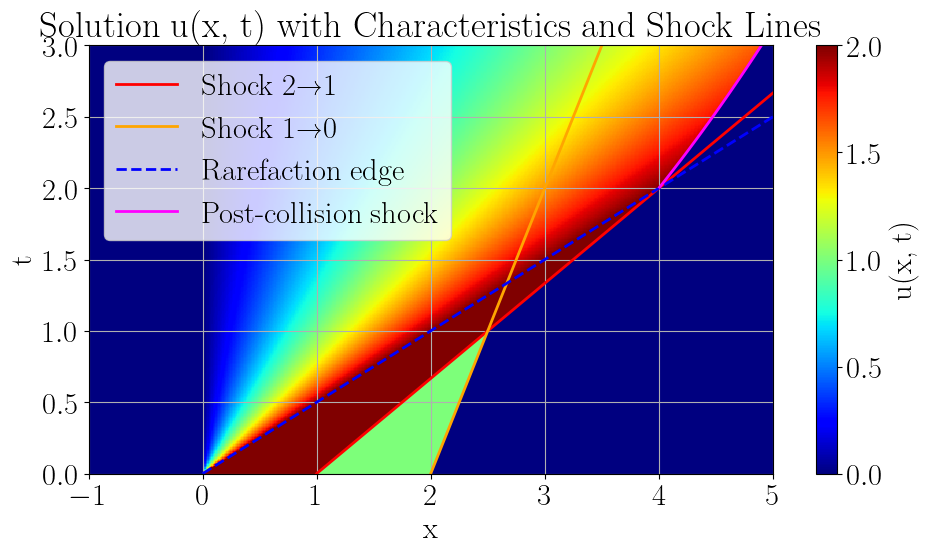

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Set the font family to serif
    "font.serif": ["Times New Roman"],  # Specify the serif font
    "font.size": 22,  # Set the default font size
})

# Create meshgrid for x-t domain
x = np.linspace(-1, 5, 500)
t = np.linspace(0, 3, 300)
X, T = np.meshgrid(x, t)

# Initialize solution array
U = np.zeros_like(X)

# Region definitions
for i in range(len(t)):
    ti = t[i]
    shock1_pos = 1 + 1.5 * ti
    shock2_pos = 2 + 0.5 * ti
    rarefaction_end = 2 * ti
    postshock = np.sqrt(8 * ti)

    for j in range(len(x)):
        xi = x[j]
        if ti <= 2:
            if xi < 0:
                U[i, j] = 0
            elif xi < rarefaction_end:
                U[i, j] = xi / ti
            elif xi < shock1_pos:
                U[i, j] = 2
            elif xi < shock2_pos:
                U[i, j] = 1
            else:
                U[i, j] = 0
        else:
            if xi < 0:
                U[i, j] = 0
            elif xi < postshock:
                U[i, j] = xi / ti
            elif xi < shock2_pos:
                U[i, j] = 1
            else:
                U[i, j] = 0

# Plot solution as colormap
fig, ax = plt.subplots(figsize=(10, 6))
c = ax.pcolormesh(X, T, U, shading='auto', cmap='jet')
plt.colorbar(c, label='u(x, t)')

# Add shock and rarefaction lines
t_vals = np.linspace(0, 3, 300)
ax.plot(1 + 1.5 * t_vals, t_vals, 'r', linewidth=2, label='Shock 2→1')
ax.plot(2 + 0.5 * t_vals, t_vals, 'orange', linewidth=2, label='Shock 1→0')
ax.plot(2 * t_vals, t_vals, 'b--', linewidth=2, label='Rarefaction edge')
ax.plot(np.sqrt(8 * t_vals[t_vals >= 2]), t_vals[t_vals >= 2], 'magenta', linewidth=2, label='Post-collision shock')

# Labels and appearance
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Solution u(x, t) with Characteristics and Shock Lines')
ax.set_xlim([-1, 5])
ax.set_ylim([0, 3])
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


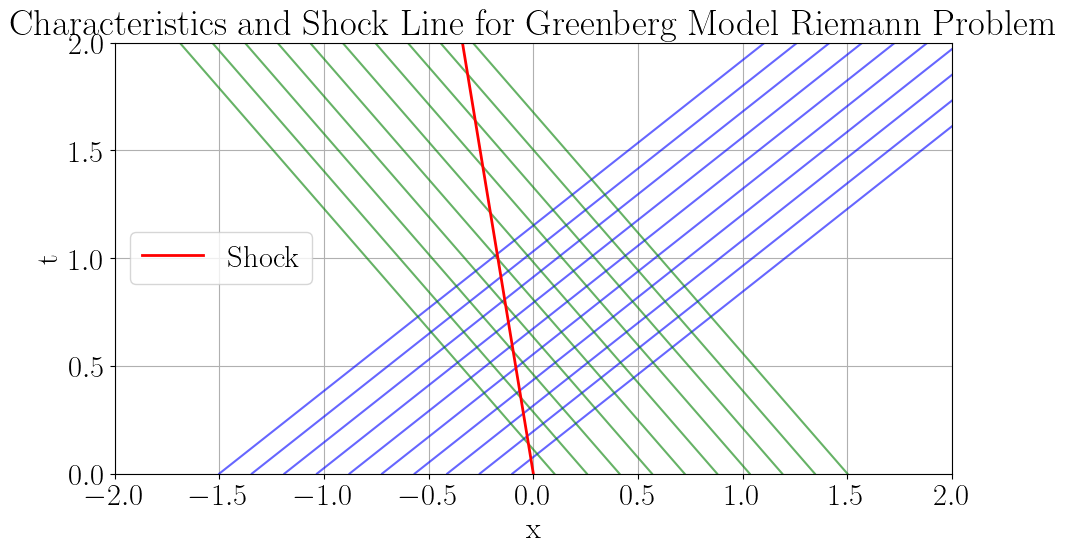

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Initial densities
rho_L = 0.1
rho_R = 0.9

# Compute characteristic speeds
def char_speed(rho):
    return -np.log(rho) - 1

s_L = char_speed(rho_L)
s_R = char_speed(rho_R)

# Compute shock speed using Rankine-Hugoniot condition
def flux(rho):
    return -rho * np.log(rho)

shock_speed = (flux(rho_R) - flux(rho_L)) / (rho_R - rho_L)

# Set up time and characteristic lines
t = np.linspace(0, 2, 200)

# Characteristic lines
x0_L = np.linspace(-1.5, -0.1, 10)
x0_R = np.linspace(0.1, 1.5, 10)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot characteristics from left and right
for x0 in x0_L:
    ax.plot(x0 + s_L * t, t, color='blue', alpha=0.6)
for x0 in x0_R:
    ax.plot(x0 + s_R * t, t, color='green', alpha=0.6)

# Plot shock line
ax.plot(shock_speed * t, t, color='red', lw=2, label='Shock')

# Labels and formatting
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Characteristics and Shock Line for Greenberg Model Riemann Problem')
ax.grid(True)
ax.legend()
ax.set_xlim([-2, 2])
ax.set_ylim([0, 2])

plt.tight_layout()
plt.show()


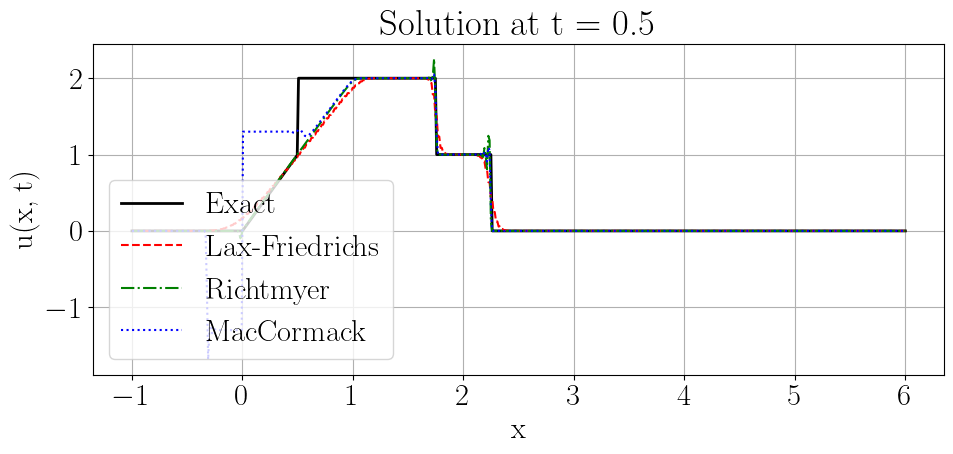

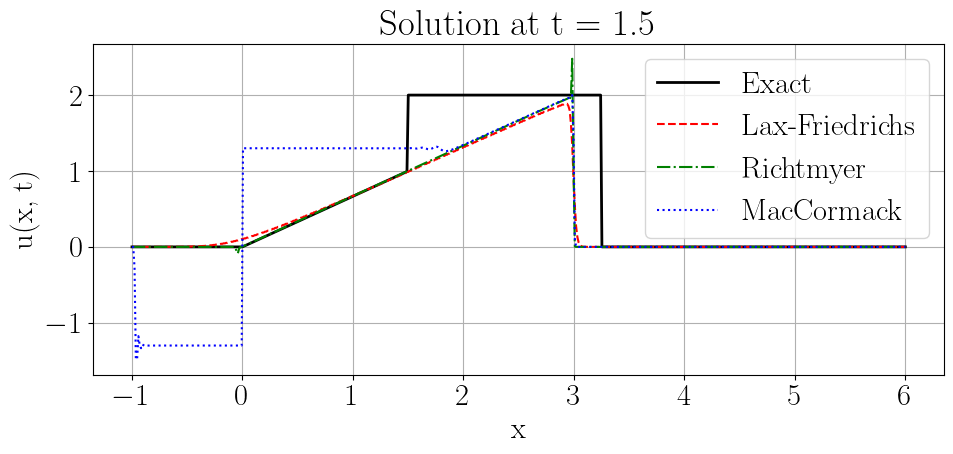

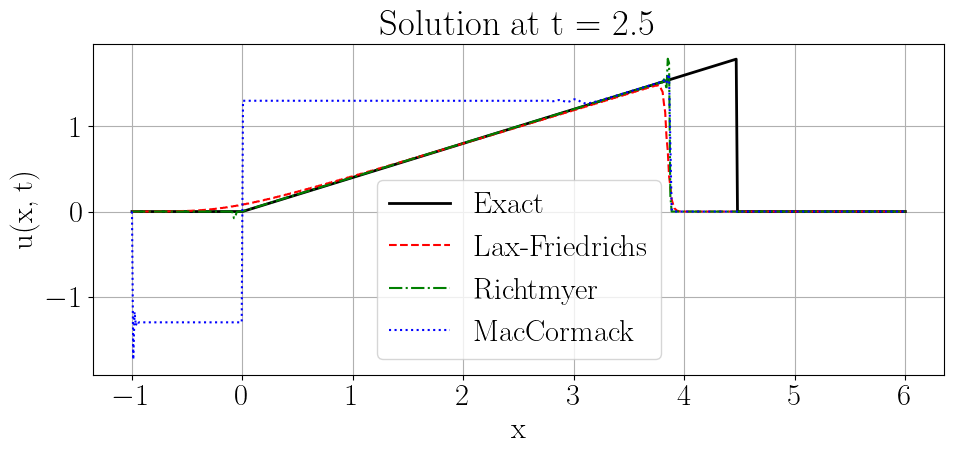

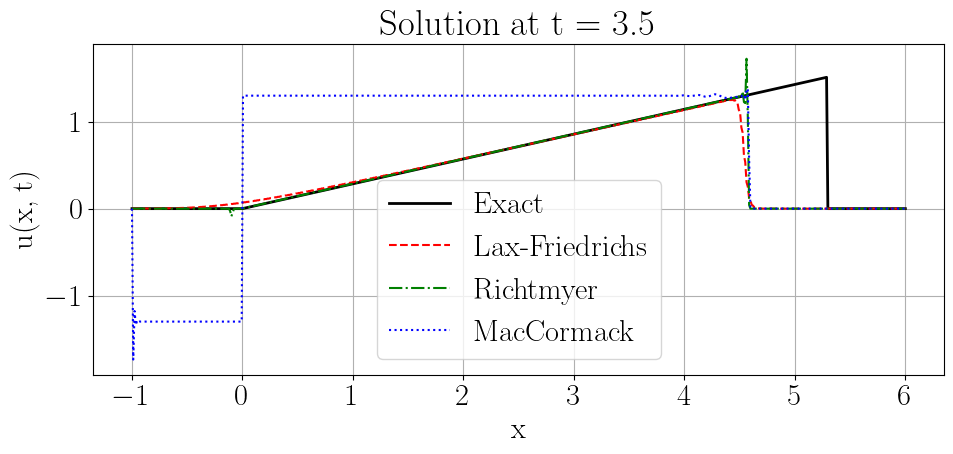

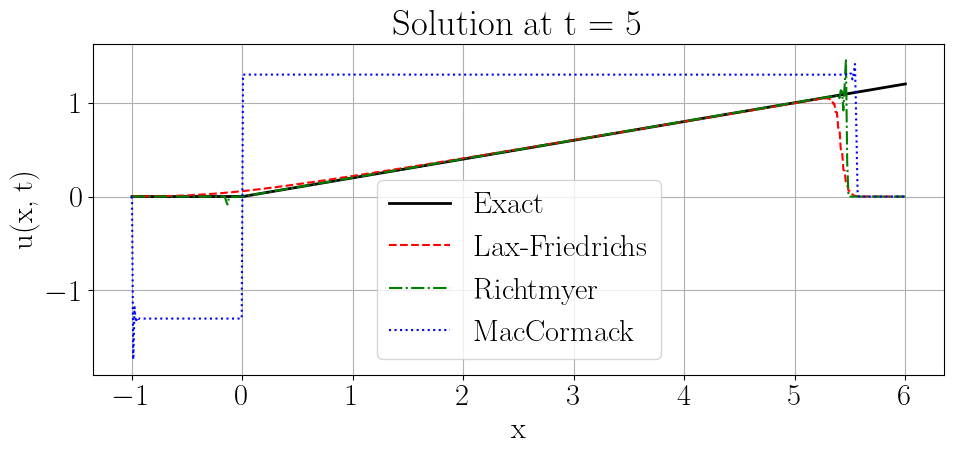

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Spatial and temporal domain
x_min, x_max = -1, 6
nx = 600
x = np.linspace(x_min, x_max, nx)
h = x[1] - x[0]
t_max = 5
cfl = 0.8
a_max = 2  # maximum speed in the domain
k = cfl * h / a_max
nt = int(t_max / k) + 1
t_vals = np.linspace(0, t_max, nt)

# Initial condition for Burgers problem
def u0(x):
    return np.piecewise(x,
                        [x < 0, (x >= 0) & (x < 1), (x >= 1) & (x < 2), x >= 2],
                        [0, 2, 1, 0])

# Flux and its derivative
def flux(u):
    return 0.5 * u**2

def dflux(u):
    return u

# Numerical methods
def lax_friedrichs(u):
    u_next = np.zeros_like(u)
    f = flux(u)
    u_next[1:-1] = 0.5 * (u[2:] + u[:-2]) - (k / (2 * h)) * (f[2:] - f[:-2])
    u_next[0], u_next[-1] = u[0], u[-1]
    return u_next

def richtmyer(u):
    f = flux(u)
    u_half = 0.5 * (u[1:] + u[:-1]) - 0.5 * k / h * (f[1:] - f[:-1])
    f_half = flux(u_half)
    u_next = np.zeros_like(u)
    u_next[1:-1] = u[1:-1] - (k / h) * (f_half[1:] - f_half[:-1])
    u_next[0], u_next[-1] = u[0], u[-1]
    return u_next

def maccormack(u):
    u_star = np.copy(u)
    f = flux(u)
    u_star[:-1] = u[:-1] - (k / h) * (f[1:] - f[:-1])
    f_star = flux(u_star)
    u_next = np.copy(u)
    u_next[1:] = 0.5 * (u[1:] + u_star[1:] - (k / h) * (f_star[1:] - f_star[:-1]))
    u_next[0] = u[0]
    return u_next

# Exact solution using method of characteristics
def exact_solution(x, t):
    u = np.zeros_like(x)
    for i in range(len(x)):
        xi = x[i]
        if t <= 2:
            if xi < 0:
                u[i] = 0
            elif xi < t:
                u[i] = xi / t
            elif xi < 1 + 1.5 * t:
                u[i] = 2
            elif xi < 2 + 0.5 * t:
                u[i] = 1
            else:
                u[i] = 0
        else:
            x_shock = np.sqrt(8 * t)
            if xi < 0:
                u[i] = 0
            elif xi < x_shock:
                u[i] = xi / t
            elif xi < 2 + 0.5 * t:
                u[i] = 1
            else:
                u[i] = 0
    return u

# Time points for output
plot_times = [0.5, 1.5, 2.5, 3.5, 5]
# Predefine containers
solutions = {
    'Lax-Friedrichs': [],
    'Richtmyer': [],
    'MacCormack': [],
    'Exact': []
}

# Initialize
u_lf = u0(x)
u_rm = u0(x)
u_mc = u0(x)

current_time = 0.0
plot_index = 0
next_plot_time = plot_times[plot_index]

# Backup previous states for interpolation
u_lf_old, u_rm_old, u_mc_old = u_lf.copy(), u_rm.copy(), u_mc.copy()
t_old = current_time

while current_time < t_max + k:
    # Take numerical step
    u_lf_new = lax_friedrichs(u_lf)
    u_rm_new = richtmyer(u_rm)
    u_mc_new = maccormack(u_mc)
    current_time += k

    # If we cross a plot time, interpolate
    while plot_index < len(plot_times) and t_old <= plot_times[plot_index] <= current_time:
        theta = (plot_times[plot_index] - t_old) / (current_time - t_old)
        interp_lf = (1 - theta) * u_lf_old + theta * u_lf_new
        interp_rm = (1 - theta) * u_rm_old + theta * u_rm_new
        interp_mc = (1 - theta) * u_mc_old + theta * u_mc_new

        solutions['Lax-Friedrichs'].append(interp_lf)
        solutions['Richtmyer'].append(interp_rm)
        solutions['MacCormack'].append(interp_mc)
        solutions['Exact'].append(exact_solution(x, plot_times[plot_index]))

        plot_index += 1
        if plot_index < len(plot_times):
            next_plot_time = plot_times[plot_index]

    # Prepare for next step
    u_lf_old, u_rm_old, u_mc_old = u_lf.copy(), u_rm.copy(), u_mc.copy()
    u_lf, u_rm, u_mc = u_lf_new, u_rm_new, u_mc_new
    t_old = current_time



# Plot
for i, t_plot in enumerate(plot_times):
    plt.figure(figsize=(10, 5))
    plt.plot(x, solutions['Exact'][i], 'k-', label='Exact', linewidth=2)
    plt.plot(x, solutions['Lax-Friedrichs'][i], 'r--', label='Lax-Friedrichs')
    plt.plot(x, solutions['Richtmyer'][i], 'g-.', label='Richtmyer')
    plt.plot(x, solutions['MacCormack'][i], 'b:', label='MacCormack')
    plt.title(f'Solution at t = {t_plot}')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
